In [1]:
import concurrent
import gc
import logging
import multiprocessing
import os
import sys
from concurrent import futures
import time

import numpy as np
import pandas as pd
import pyarrow as pa
import scipy.sparse
import scipy.sparse
import tiledb
import seaborn as sns
import tiledbsoma as soma
from somacore import ExperimentAxisQuery, AxisQuery
from tiledb import ZstdFilter, ArraySchema, Domain, Dim, Attr, FilterList
import statsmodels.api as sm

In [2]:
import sys
sys.path.append('/home/ubuntu/Github/scrna-parameter-estimation/')
import memento

In [11]:
def treatment_assignment(row):

    ct = row['cell_type']
    if 'plasma' in ct:
        return 'pdc'
    if 'conven' in ct or 'myeloid' in ct:
        return 'cdc'
    else:
        return 'unknown'

In [3]:
dataset_ids_to_query = ['c7775e88-49bf-4ba2-a03b-93f00447c958', '218acb0f-9f2f-4f76-b90b-15a4b7c7f629', '4c4cd77c-8fee-4836-9145-16562a8782fe']
dataset_query = '('
for idx, di in enumerate(dataset_ids_to_query): 
    dataset_query += f'dataset_id == "{di}" '
    if idx != len(dataset_ids_to_query)-1:
        dataset_query += 'or '
dataset_query += ')'

celltypes_to_query = [
    'conventional dendritic cell',
    'plasmacytoid dendritic cell',
    'conventional dendritic cell',
    'plasmacytoid dendritic cell, human',
    'dendritic cell',
    'dendritic cell, human',
    'myeloid dendritic cell',
    'plasmacytoid dendritic cell']
celltype_query = '('
for idx, ct in enumerate(celltypes_to_query): 
    celltype_query += f'cell_type == "{ct}" '
    if idx != len(celltypes_to_query)-1:
        celltype_query += 'or '
celltype_query += ')'

OBS_VALUE_FILTER_1 = dataset_query # All cells in three datasets
OBS_VALUE_FILTER_2 = celltype_query + ' and ' + celltype_query # only relevant celltypes

exp_uri = 's3://cellxgene-data-public/cell-census/2023-10-30/soma/census_data/homo_sapiens'
layer = "raw"
measurement_name = "RNA"

with soma.Experiment.open(uri=exp_uri,
                          context=soma.SOMATileDBContext().replace(tiledb_config={
                              "vfs.s3.region":"us-west-2",
                              "vfs.s3.no_sign_request":True})
                          ) as exp:

    query = exp.axis_query(measurement_name=measurement_name,
                           obs_query=AxisQuery(value_filter=OBS_VALUE_FILTER_2),
                           # Note: Must use *all* genes to compute size factors correctly, even when var filter is
                           # being used for testing
                           var_query=AxisQuery())

In [5]:
obs_df = query.obs().concat().to_pandas()
# var_df = query.var().concat().to_pandas()

In [14]:
DE_TREATMENT = 'treatment'
DE_COVARIATES = ['donor_id']
DE_VARIABLES = [DE_TREATMENT] + DE_COVARIATES

In [16]:
cell_count = obs_df.groupby(['cell_type', 'donor_id']).size().reset_index(name='count')
cell_count['treatment'] = cell_count.apply(treatment_assignment, axis=1)

names = cell_count[DE_TREATMENT].copy()
for col in DE_COVARIATES:
    names += '_' + cell_count[col]
cell_count['group_name'] = names.tolist()
cell_count = cell_count.set_index('group_name')

In [21]:
cell_count

,cell_type,donor_id,count,treatment
group_name,,,,
cdc_1000_1001,conventional dendritic cell,1000_1001,7,cdc
cdc_1001_1002,conventional dendritic cell,1001_1002,5,cdc
cdc_1002_1003,conventional dendritic cell,1002_1003,4,cdc
cdc_1003_1004,conventional dendritic cell,1003_1004,4,cdc
cdc_1004,conventional dendritic cell,1004,32,cdc
...,...,...,...,...
pdc_pt18,"plasmacytoid dendritic cell, human",pt18,102,pdc
pdc_pt19,"plasmacytoid dendritic cell, human",pt19,153,pdc
pdc_pt20,"plasmacytoid dendritic cell, human",pt20,15,pdc


In [9]:
import scanpy as sc

In [10]:
# adata = query.to_anndata('raw')

In [11]:
# adata.write('temp.h5ad')
adata = sc.read_h5ad('temp.h5ad')

In [36]:
adata.var = adata.var.set_index('feature_id')

In [43]:
df = adata.obs.copy()
df['expr'] = adata[:, 'ENSG00000002330'].X.toarray().ravel()

In [49]:
df.query('donor_id == "1763"').groupby('cell_type')['expr'].sum()

/tmp/ipykernel_36483/3274465207.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.query('donor_id == "1763"').groupby('cell_type')['expr'].sum()


cell_type
B cell                              35.0
CD4-positive, alpha-beta T cell     94.0
CD8-positive, alpha-beta T cell    270.0
classical monocyte                 255.0
conventional dendritic cell          8.0
lymphocyte                          50.0
natural killer cell                 47.0
non-classical monocyte              68.0
plasmablast                          8.0
plasmacytoid dendritic cell          6.0
progenitor cell                      0.0
Name: expr, dtype: float32

In [46]:
df[df['cell_type'].str.contains('dendritic')].groupby(['cell_type', 'donor_id'])['expr'].sum()

/tmp/ipykernel_36483/1176132240.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[df['cell_type'].str.contains('dendritic')].groupby(['cell_type', 'donor_id'])['expr'].sum()


cell_type        donor_id
B cell           1004        0.0
                 1014        0.0
                 1015        0.0
                 1019        0.0
                 1022        0.0
                            ... 
progenitor cell  IGTB1982    0.0
                 IGTB1987    0.0
                 IGTB1996    0.0
                 IGTB2007    0.0
                 IGTB2065    0.0
Name: expr, Length: 2871, dtype: float32

In [102]:
adata.obs.donor_id.drop_duplicates().shape

(261,)

In [12]:
adata.shape

(1263676, 60664)

In [10]:
adata.var.index = adata.var.feature_id.values

In [98]:
adata.obs.query('cell_type == "plasmacytoid dendritic cell"').donor_id.value_counts().head(100)

donor_id
1545        121
IGTB195     106
IGTB143      93
IGTB256      93
IGTB1921     92
           ... 
1768         19
1886         19
IGTB1826     19
1614         19
HC-563       19
Name: count, Length: 100, dtype: int64

In [99]:
X1 = adata[(adata.obs['donor_id'] == '1614') & (adata.obs['cell_type'] == 'plasmacytoid dendritic cell')].X.toarray()
X2 = adata[(adata.obs['donor_id'] == '1614') & (adata.obs['cell_type'] == 'conventional dendritic cell')].X.toarray()


sf1 = X1.sum(axis=1)
sf2 = X2.sum(axis=1)
m1 = (X1/sf1.reshape(-1,1)).mean(axis=0)
m2 = (X2/sf2.reshape(-1,1)).mean(axis=0)

idx = (m1>0) & (m2>0)
m1 = m1[idx]
m2 = m2[idx]

In [100]:
m1

array([2.65596464e-05, 1.37670895e-05, 1.28213351e-05, ...,
       2.76242008e-05, 4.52161330e-05, 3.29978539e-05], dtype=float32)

<Axes: ylabel='Density'>

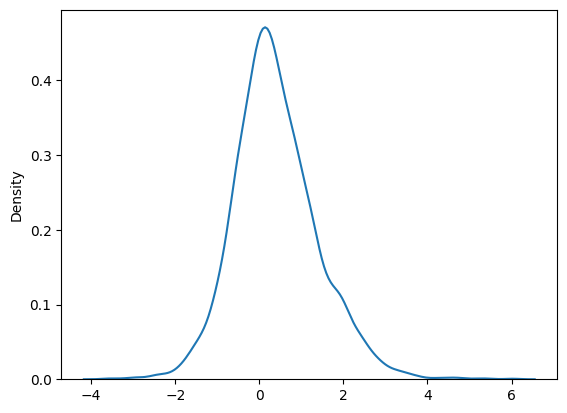

In [101]:
sns.kdeplot(np.log(m1/m2))

In [87]:
X2.shape

(160, 60664)

In [88]:
X1.shape

(92, 60664)

<Axes: ylabel='Density'>

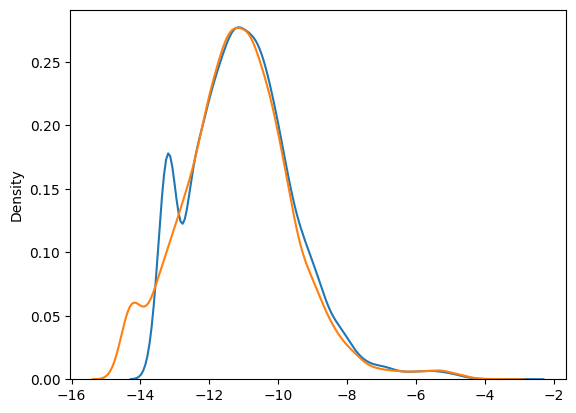

In [89]:
sns.kdeplot(np.log(m1))
sns.kdeplot(np.log(m2))

In [12]:
adata[(adata.obs['donor_id'] == '1031') & (adata.obs['cell_type'] == 'conventional dendritic cell')].X.todense().shape


(60, 60664)

In [13]:
def run_memento(ct1, ct2):
    
    adata = all_adata[all_adata.obs['cell_type'].isin([ct1, ct2])].copy().copy()

    adata.obs['q'] = 0.07
    memento.setup_memento(adata, q_column='q', trim_percent=1, filter_mean_thresh=0.01, shrinkage=0)
    memento.create_groups(adata, label_columns=['cell_type', 'donor_id'])
    memento.compute_1d_moments(adata, min_perc_group=.7)

    meta_df = memento.get_groups(adata)
    meta_df['intercept'] = 1
    covariate = meta_df[['intercept']]
    treatment = (meta_df[['cell_type']] == ct2).astype(float)
        

    memento.ht_1d_moments(
        adata, 
        covariate=covariate,
        treatment=treatment, 
        num_boot=5000, 
        verbose=1,
        num_cpus=13,
        resample_rep=False,
        approx=True)
    memento_results = memento.get_1d_ht_result(adata)
    
    return memento_results

In [39]:
adata = sc.read_h5ad('temp.h5ad')

In [40]:
donor_list = [
    '1004',
 '1014',
 '1015',
 '1019',
    
    
    
 '1022',
 '1031',
    
    
    
 '1039',
 '1045',
 '1046',
 '1051',
 '1054',
 '1056',
 '1063',
]

In [41]:
test_adata = adata[(adata.obs['donor_id'].isin(donor_list)) ].copy().copy()

In [42]:
test_adata = test_adata[test_adata.obs['cell_type'].isin(['plasmacytoid dendritic cell',  'conventional dendritic cell'])]
test_adata.obs['q'] = 0.07
memento.setup_memento(test_adata, q_column='q', trim_percent=1, filter_mean_thresh=0.01, shrinkage=0, )

/tmp/ipykernel_196051/193996687.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  test_adata.obs['q'] = 0.07


In [47]:
memento.create_groups(test_adata, label_columns=['cell_type', 'donor_id'])
memento.compute_1d_moments(test_adata, min_perc_group=.6)

In [48]:
meta_df = memento.get_groups(test_adata).astype(str)
# meta_df['intercept'] = 1
treatment = (meta_df[['cell_type']] == 'conventional dendritic cell').astype(float)
covariate = pd.get_dummies(meta_df[['donor_id']], drop_first=True)

covariate -= covariate.mean(axis=0)

interaction_df = covariate*treatment[['cell_type']].values
interaction_df.columns=[f'interaction_{col}' for col in covariate.columns]

covariate = pd.concat([covariate, interaction_df], axis=1)
covariate = sm.add_constant(covariate)



In [49]:
memento.ht_1d_moments(
    test_adata, 
    covariate=covariate,
    treatment=treatment, 
    num_boot=5000, 
    verbose=1,
    num_cpus=13,
    resample_rep=False,
    approx=True)
memento_results = memento.get_1d_ht_result(test_adata)

[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    0.6s
[Parallel(n_jobs=13)]: Done 322 tasks      | elapsed:    5.9s
[Parallel(n_jobs=13)]: Done 467 out of 467 | elapsed:    8.5s finished


<Axes: >

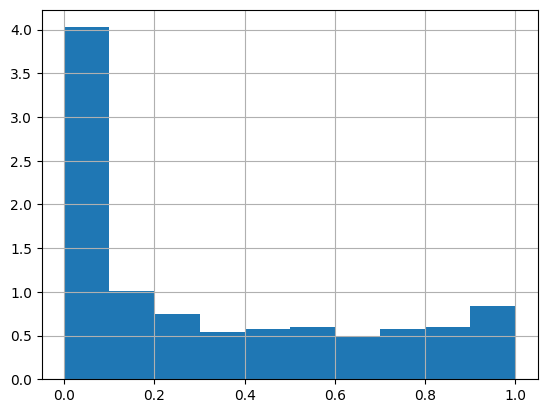

In [50]:
memento_results['de_pval'].hist(density=True)

In [104]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
%autoreload 2

In [50]:
mem_result = run_memento('plasmacytoid dendritic cell',  'conventional dendritic cell')

[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=13)]: Done 950 tasks      | elapsed:    1.8s
[Parallel(n_jobs=13)]: Done 2382 out of 2407 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=13)]: Done 2407 out of 2407 | elapsed:    4.3s finished


<Axes: >

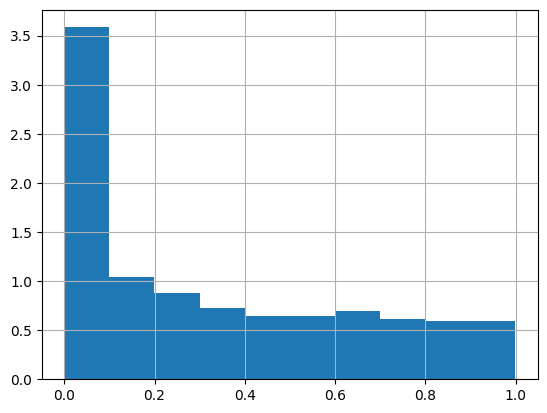

In [52]:
mem_result['de_pval'].hist(density=True)

In [10]:
counts = obs_df.groupby(['dataset_id', 'cell_type']).size().reset_index(name='count')

In [30]:
adata

AnnData object with n_obs × n_vars = 362619 × 60664
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'

In [14]:
adata[(adata.obs['cell_type'] == 'plasmacytoid dendritic cell')].shape

(5233, 60664)

In [67]:
counts = obs_df.groupby(['dataset_id', 'cell_type']).size().reset_index(name='count')

In [68]:
counts.query('dataset_id == "218acb0f-9f2f-4f76-b90b-15a4b7c7f629"')

,dataset_id,cell_type,count
0,218acb0f-9f2f-4f76-b90b-15a4b7c7f629,conventional dendritic cell,18203
1,218acb0f-9f2f-4f76-b90b-15a4b7c7f629,plasmacytoid dendritic cell,5233


### Composite hypotheses

In [73]:
import scipy.stats as stats
import matplotlib.pyplot as plt

In [213]:
# ONE SIDED TEST

num_trials = 10000
num_cells = 500
pop_mean = 0.05
mu = stats.norm.rvs(loc=0, scale=0.1, size=num_trials )
pvalues = np.zeros(num_trials)
tstats = np.zeros(num_trials)
for trial in range(num_trials):
    
    data = stats.norm.rvs(loc=mu[trial], scale=1, size=num_cells)
    tstat, pval = stats.ttest_1samp(data, pop_mean, alternative='greater')
    tstats[trial] = tstat
    pvalues[trial] = pval*2
    

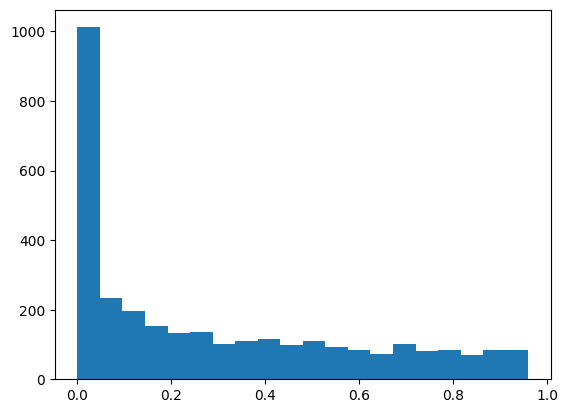

In [214]:
plt.hist(pvalues[tstats > pop_mean], bins=20);

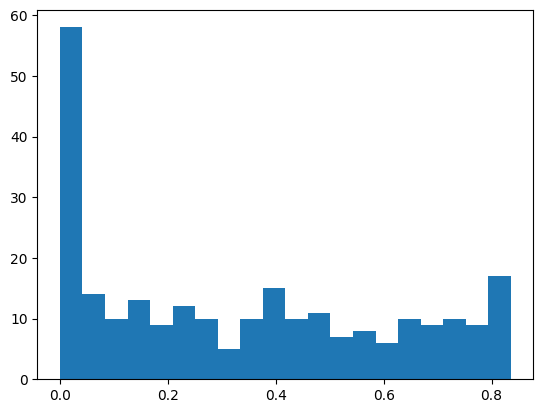

In [194]:
plt.hist(pvalues[tstats > pop_mean], bins=20);